In [1]:
import torch
import torch.nn as nn

# Calcula la matriz de distancias por pares con estabilidad numérica.
#   output[i, j] = || feature[i, :] - feature[j, :] ||_2
#   Args:
#     embeddings: Tensor 2-D de tamaño [número de datos, dimensión de características].
#   Returns:
#     distancias_por_pares: Tensor 2-D de tamaño [número de datos, número de datos].
def distancia_por_pares_torch(embeddings, dispositivo):

    # matriz de distancias por pares con embeddings precisos
    embeddings_precisos = embeddings.to(dtype=torch.float32)

    c1 = torch.pow(embeddings_precisos, 2).sum(axis=-1)
    c2 = torch.pow(embeddings_precisos.transpose(0, 1), 2).sum(axis=0)
    c3 = embeddings_precisos @ embeddings_precisos.transpose(0, 1)

    c1 = c1.reshape((c1.shape[0], 1))
    c2 = c2.reshape((1, c2.shape[0]))
    c12 = c1 + c2
    distancias_por_pares_cuadradas = c12 - 2.0 * c3

    # Manejar inexactitudes numéricas. Establecer pequeños negativos a cero.
    distancias_por_pares_cuadradas = torch.max(distancias_por_pares_cuadradas, torch.tensor([0.]).to(dispositivo))

    # Obtener la máscara donde están las distancias cero.
    mascara_error = distancias_por_pares_cuadradas.clone()
    mascara_error[mascara_error > 0.0] = 1.
    mascara_error[mascara_error <= 0.0] = 0.

    distancias_por_pares = torch.mul(distancias_por_pares_cuadradas, mascara_error)

    # Establecer explícitamente las diagonales a cero.
    mascara_no_diagonales = torch.ones((distancias_por_pares.shape[0], distancias_por_pares.shape[1])) - torch.diag(torch.ones(distancias_por_pares.shape[0]))
    distancias_por_pares = torch.mul(distancias_por_pares.to(dispositivo), mascara_no_diagonales.to(dispositivo))
    return distancias_por_pares

# Calcula las triplet loss functions con minería negativa semi-dura (en inglés semi-hard negative mining).
# La pérdida anima a las distancias positivas (entre un par de embeddings
# con las mismas etiquetas) a ser menores que la distancia negativa mínima
# entre las cuales son al menos mayores que la distancia positiva más el
# término de margen constante (llamado semi-dura) en el mini-lote.
# Si no existe tal negativa, utiliza la distancia negativa más grande en su lugar.
#
# Ver: https://arxiv.org/abs/1503.03832.
#
# Esperamos que las etiquetas `y_real` se proporcionen como un `Tensor` entero 1-D con forma
# [tamaño_lote] de etiquetas enteras de múltiples clases. Y los embeddings `y_pred` deben ser
# un `Tensor` de punto flotante 2-D de vectores de embedding normalizados l2.
#   Args:
#     margen: Flotante, término de margen en la definición de la pérdida. El valor predeterminado es 1.0.
#     nombre: Nombre opcional para la operación.
def TripletSemiHardLoss(y_real, y_pred, dispositivo, margen=1.0):

    etiquetas, embeddings = y_real, y_pred

    # Cambiar la forma del tensor de etiquetas a [tamaño_lote, 1].
    forma_etiquetas = etiquetas.shape
    etiquetas = torch.reshape(etiquetas, [forma_etiquetas[0], 1])

    matriz_distancias = distancia_por_pares_torch(embeddings, dispositivo)

    # Construir matriz de adyacencia binaria por pares.
    adyacencia = torch.eq(etiquetas, etiquetas.transpose(0, 1))
    # Invertir para que podamos seleccionar solo negativos.
    adyacencia_no = adyacencia.logical_not()

    tam_lote = etiquetas.shape[0]

    # Calcular la máscara.
    matriz_distancias_repetida = matriz_distancias.repeat(tam_lote, 1)
    adyacencia_no_repetida = adyacencia_no.repeat(tam_lote, 1)

    transponer_reformar = matriz_distancias.transpose(0, 1).reshape(-1, 1)
    mayor = matriz_distancias_repetida > transponer_reformar

    mascara = adyacencia_no_repetida & mayor

    # máscara final
    mascara2 = mascara.to(dtype=torch.float32)
    mascara2 = mascara2.sum(axis=1)
    mascara2 = mascara2 > 0.0
    mascara_final = mascara2.reshape(tam_lote, tam_lote)
    mascara_final = mascara_final.transpose(0, 1)

    adyacencia_no = adyacencia_no.to(dtype=torch.float32)
    mascara = mascara.to(dtype=torch.float32)

    # negativos_fuera: D_an más pequeño donde D_an > D_ap.
    maximos_ejes = torch.max(matriz_distancias_repetida, dim=1, keepdim=True)
    minimos_enmascarados = torch.min(torch.mul(matriz_distancias_repetida - maximos_ejes[0], mascara), dim=1, keepdim=True)[0] + maximos_ejes[0]
    negativos_fuera = minimos_enmascarados.reshape([tam_lote, tam_lote])
    negativos_fuera = negativos_fuera.transpose(0, 1)

    # negativos_dentro: D_an más grande.
    minimos_ejes = torch.min(matriz_distancias, dim=1, keepdim=True)
    maximos_enmascarados = torch.max(torch.mul(matriz_distancias - minimos_ejes[0], adyacencia_no), dim=1, keepdim=True)[0] + minimos_ejes[0]
    negativos_dentro = maximos_enmascarados.repeat(1, tam_lote)

    negativos_semi_duros = torch.where(mascara_final, negativos_fuera, negativos_dentro)

    matriz_perdida = margen + matriz_distancias - negativos_semi_duros

    mascara_positivos = adyacencia.to(dtype=torch.float32) - torch.diag(torch.ones(tam_lote)).to(dispositivo)
    num_positivos = mascara_positivos.sum()

    triplet_loss = (torch.max(torch.mul(matriz_perdida, mascara_positivos), torch.tensor([0.]).to(dispositivo))).sum() / num_positivos
    triplet_loss = triplet_loss.to(dtype=embeddings.dtype)

    return triplet_loss


class TripletLoss(nn.Module):
    def __init__(self, dispositivo):
        super().__init__()
        self.dispositivo = dispositivo

    def forward(self, entrada, objetivo, **kwargs):
        return TripletSemiHardLoss(objetivo, entrada, self.dispositivo)

In [2]:
from fastai.vision import *
from fastai.basics import *
from fastai.vision.all import *
from fastai.vision.augment import *
from fastai.vision.learner import cnn_learner
from fastai.vision.models import resnet34
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders

import torchvision

from scipy import spatial
import logging

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.manifold import TSNE
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid


In [3]:
dispositivo = 0
torch.cuda.set_device(dispositivo)

AQUI ES DONDE ELEGIMOS EL DATASET. SE PUEDE CAMBIAR AL QUE QUERAMOS !!!!

In [4]:
# https://docs.fast.ai/data.external.html
birds = untar_data(URLs.CUB_200_2011)

fnomb = get_image_files(birds)

In [67]:
with open('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images.txt') as file:
    images_list = file.readlines()
    images_list = [line.rstrip() for line in images_list]
# print(images_list) En GITHUB sale muy largo porque no sale en una línea solo. Decido omitirlo por ahora.

In [15]:
# La etiqueta correcta para una imagen es el nombre del directorio en el que se encuentra.
# Por ejemplo, "1" es la etiqueta correcta para "1/1.png"

def Etiqueta(x):
  return x.parent.name

dls = ImageDataLoaders.from_path_func(birds, fnomb, Etiqueta, item_tfms=Resize(224)) # Importante redimensionar las imágenes para que TODAS tengan EL MISMO TAMAÑO

In [16]:
embedding_long = 128

DECLARAMOS EL OBJETO LEARN VISTO EN PRÁCTICAS USANDO COMO FUNCIÓN DE PÉRDIDA LA FUNCIÓN TRIPLET LOSS RECIÉN DEFINIDA.

MÉTRICA -> EXACTITUD (ACCURACY)

MODELO USADO -> RESNET5O

In [17]:
learn = cnn_learner(dls, resnet50, metrics=accuracy, loss_func=TripletLoss(dispositivo))

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [18]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=200, bias=False)
)

 QUEREMOS SUSTITUIR EL HEAD DE ESTE MODELO POR UN "EMBEDDING OUTPUT" APROPIADO PARA ESTE PROBLEMA

CREAMOS UNA CLASE QUE NORMALIZA LOS VALORES ENTRE 0 Y 1

In [19]:
class Norm_L2(nn.Module):
    def __init__(self):
        super(Norm_L2, self).__init__()

    def forward(self, x):
        return F.normalize(x, p=2, dim=-1)

SUSTITUIMOS EL HEAD (A PARTIR DE LA PRIMERA CAPA FC)

In [20]:
capas = learn.model[1]
learn.model[1] = nn.Sequential(
                               capas[0],
                               capas[1],
                               capas[2],
                               capas[3],
                               nn.Linear(in_features=4096, out_features=embedding_long, bias=False),  # Esta capa será la nueva capa FC de nuestro problema
                               Norm_L2()                                                              # Capa que normaliza la salida entre 0 y 1
                              ).to(dispositivo)


In [21]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=128, bias=False)
  (5): Norm_L2()
)

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Tasa de aprendizaje usada: 0.05754399299621582 



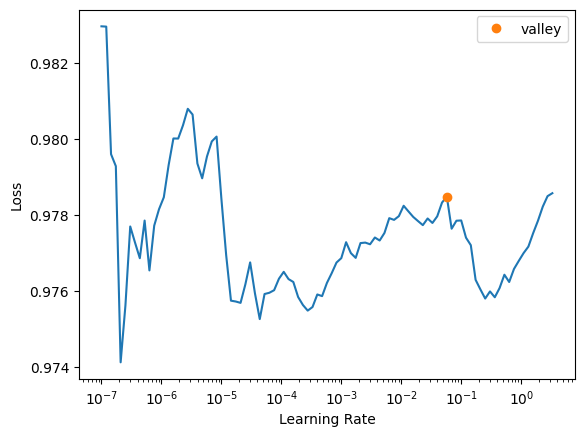

In [22]:
learnr = learn.lr_find()
print(f'Tasa de aprendizaje usada: {learnr[0]} \n')

In [23]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

epoch,train_loss,valid_loss,accuracy,time
0,0.969161,0.941032,0.005515,01:31
1,0.939647,0.886499,0.004243,01:30
2,0.910368,0.882191,0.002970,01:37
3,0.895283,0.902950,0.006364,01:35
4,0.908580,0.903593,0.003818,01:43
5,0.913111,0.907179,0.005940,01:41
6,0.909206,0.909925,0.002546,01:46
7,0.904572,0.899224,0.004243,01:42


No improvement since epoch 2: early stopping


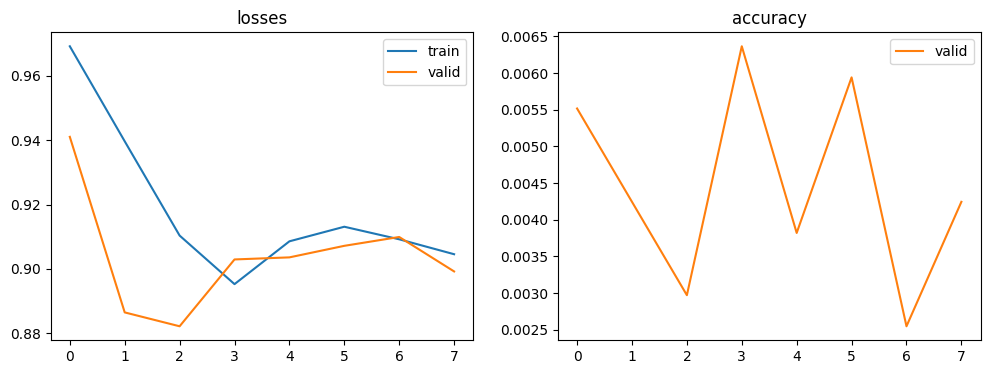

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

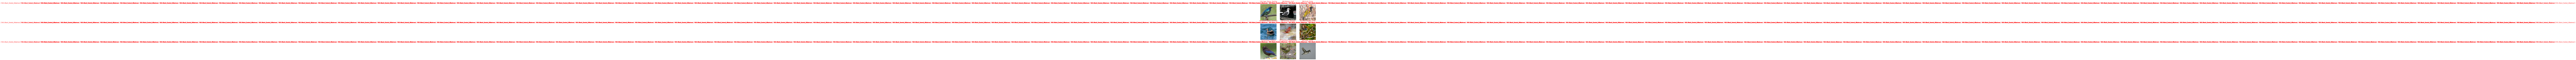

In [24]:
# Entrenamos la red usando la política 1cycle de Leslie N
learn.fit_one_cycle(n_epoch = 25, lr_max = learnr[0], cbs = EarlyStoppingCallback(patience = 5))

# Mostramos la curva de exactitud en validación a lo largo de las diferentes épocas
learn.recorder.plot_metrics()

# Mostramos los resultados tras el entrenamiento del modelo
learn.show_results()

# Mostramos los detalles del objeto Learner usando su método summary() antes descrito
learn.summary()

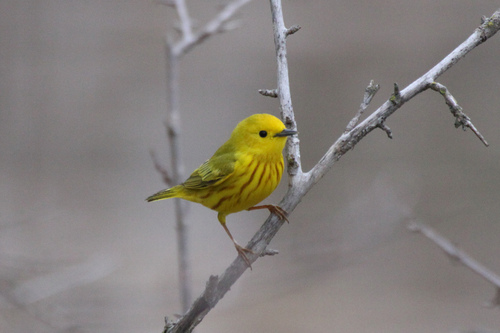

In [47]:
PILImage.create('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/182.Yellow_Warbler/Yellow_Warbler_0063_176800.jpg')

In [30]:
imagen_consulta = PILImage.create('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/182.Yellow_Warbler/Yellow_Warbler_0063_176800.jpg')
resultado = learn.predict(imagen_consulta)
fingerprint_consulta = resultado[1].numpy()
print(fingerprint_consulta)

[-2.24678889e-02 -1.54939011e-01 -3.16633917e-02  1.08324885e-02
 -7.95804784e-02  1.40463896e-02  4.22434919e-02  7.00312778e-02
 -1.16550047e-02  7.33731240e-02  8.30187723e-02 -3.02847512e-02
  2.46385876e-02 -8.45499933e-02  1.24773189e-01 -8.69143009e-02
  9.21253413e-02 -5.06438836e-02 -1.32435352e-01  6.23937398e-02
  1.00033350e-01 -1.62765570e-02  1.78608835e-01  1.20082475e-01
 -2.56572366e-02  5.93404248e-02  3.02254520e-02  7.35327229e-02
 -1.52140241e-02  8.40065703e-02  1.17068961e-01 -8.33237022e-02
  1.34847954e-01 -1.74169168e-02  5.36856800e-02  7.66502172e-02
 -3.40745375e-02 -4.02871147e-02 -9.69008952e-02 -6.08104235e-03
  3.21097635e-02 -1.39971510e-01 -2.10109219e-01  1.53326057e-03
  1.37611097e-02 -1.14904307e-02 -3.49073149e-02 -1.35148972e-01
  9.32271034e-02  1.08638294e-01 -1.49245143e-01 -5.07665798e-02
 -4.09831516e-02 -4.67192382e-02  5.01143932e-02 -1.12105519e-01
  3.46182846e-02  1.14171393e-01 -1.04724661e-01 -2.56995820e-02
 -3.86286639e-02  7.66322

Creamos la base de datos que usaremos para comparar las diferentes huellas (fingerprints en inglés) obtenidas:

In [35]:
#fnomb2 = list(Path(fnomb).rglob('*.jpg')) # NO HACE FALTA PORQUE USAMOS images_list que YA tiene todas las imágenes
len(images_list)

11788

In [36]:
images_list[0]

'1 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg'

In [39]:
# Genera una línea en blanco por cada uno por alguna razón. Usa %%capture al llamar
def Fingerprints(fnomb):
    fingerprints = {}
    for f in fnomb:
        # Convertir la cadena 'f' a un objeto Path
        f = Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/' + f.split(' ')[1]) # AQUÍ ES DIFERENTE AL TUTORIAL. DEBEMOS PASAR A OBJETO DEL TIPO PATH
        categoria = Etiqueta(f)
        img = PILImage.create(f)
        resultado = learn.predict(img)
        fingerprint = resultado[1].numpy()
        fingerprints[(categoria, f)] = fingerprint
    return fingerprints

In [40]:
%%capture
# Suprime la salida
fingerprints_DB = Fingerprints(images_list)

ENCONTRAR LOS K-VECINOS MÁS CERCANOS SERÁ FÁCIL PORQUE RECORDEMOS QUE HEMOS NORMALIZADO LA SALIDA ENTRE 0 Y 1

In [41]:
# Encuentra los k vecinos más cercanos utilizando similitud coseno. Recordemos que contamos con los vectores normalizados entre 0 y 1
def K_vecinos_cercanos(vectores, vec, k):
    distancias = np.matmul(vectores, vec.T)
    return np.argsort(-distancias.flatten())[:k]

In [42]:
fps = list(fingerprints_DB.values())
cercano = K_vecinos_cercanos(fps, fingerprint_consulta, 10) # Recordemos que en este caso será de un Yellow Warbler
cercano

array([10696,  9777,  9186,  5507, 10254, 10275, 10278, 10689, 10279,
       10711])

In [43]:
list(fingerprints_DB.items())[cercano[0]]

(('182.Yellow_Warbler',
  Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/182.Yellow_Warbler/Yellow_Warbler_0063_176800.jpg')),
 array([-2.24678889e-02, -1.54939011e-01, -3.16633917e-02,  1.08324885e-02,
        -7.95804784e-02,  1.40463896e-02,  4.22434919e-02,  7.00312778e-02,
        -1.16550047e-02,  7.33731240e-02,  8.30187723e-02, -3.02847512e-02,
         2.46385876e-02, -8.45499933e-02,  1.24773189e-01, -8.69143009e-02,
         9.21253413e-02, -5.06438836e-02, -1.32435352e-01,  6.23937398e-02,
         1.00033350e-01, -1.62765570e-02,  1.78608835e-01,  1.20082475e-01,
        -2.56572366e-02,  5.93404248e-02,  3.02254520e-02,  7.35327229e-02,
        -1.52140241e-02,  8.40065703e-02,  1.17068961e-01, -8.33237022e-02,
         1.34847954e-01, -1.74169168e-02,  5.36856800e-02,  7.66502172e-02,
        -3.40745375e-02, -4.02871147e-02, -9.69008952e-02, -6.08104235e-03,
         3.21097635e-02, -1.39971510e-01, -2.10109219e-01,  1.53326057e-03,
         1.37611097e-02, -

In [60]:
## Juntamos todo

def Mejor_coincidencia(fingerprints_DB, fingerprint, k):
    fingerprints = list(fingerprints_DB.values())
    claves = list(fingerprints_DB.keys())
    indices_coincidencias = K_vecinos_cercanos(fingerprints, fingerprint, k)
    for i in indices_coincidencias:
        fingerprint_coincidente = fingerprints[i]
        distancia = spatial.distance.cosine(fingerprint_coincidente, fingerprint)
        yield (claves[i], distancia)

resultadoFINAL = list(Mejor_coincidencia(fingerprints_DB, fingerprint_consulta, 10))

for item in resultadoFINAL:
    print(item)

(('182.Yellow_Warbler', Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/182.Yellow_Warbler/Yellow_Warbler_0063_176800.jpg')), 0.0)
(('167.Hooded_Warbler', Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/167.Hooded_Warbler/Hooded_Warbler_0017_164911.jpg')), 0.07662367820739746)
(('157.Yellow_throated_Vireo', Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/157.Yellow_throated_Vireo/Yellow_Throated_Vireo_0021_794971.jpg')), 0.08297712105376087)
(('095.Baltimore_Oriole', Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/095.Baltimore_Oriole/Baltimore_Oriole_0090_87054.jpg')), 0.08624672889709473)
(('175.Pine_Warbler', Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/175.Pine_Warbler/Pine_Warbler_0032_172080.jpg')), 0.08840838865116374)
(('175.Pine_Warbler', Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/175.Pine_Warbler/Pine_Warbler_0097_171671.jpg')), 0.09283129210751517)
(('175.Pine_Warbler', Path('/root/.fastai/data/CUB_200_2011/

Observamos que lo que hemos obtenido como mejores matches son:

- 3 Yellow Warbler (Contando el original que de hecho hemos obtenido una distancia de similitud coseno de 0, como debería ser)

- 4 Pine Warbler. Es entendible esta confusión. Ambos son Warblers. Sin embargo, hemos obtenido hasta más matches de un pájaro que NO es el que buscamos.

- 1 Yellow Throated Vireo. Es entendible está confusión también. Es un pájaro también amarillo. Podemos ver que esta confusión no es tan preocupante como antes.

- 1 Hooded Warbler. Si vemos la imagen, es entendible de hecho la confusión. Ambos son amarillos. No es tan preocupante.

- 1 Baltimore Oriole. Si vemos la imagen, es entendible de hecho la confusión. Ambos son amarillos. No es tan preocupante.

/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/182.Yellow_Warbler/Yellow_Warbler_0063_176800.jpg
/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/167.Hooded_Warbler/Hooded_Warbler_0017_164911.jpg
/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/157.Yellow_throated_Vireo/Yellow_Throated_Vireo_0021_794971.jpg
/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/095.Baltimore_Oriole/Baltimore_Oriole_0090_87054.jpg
/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/175.Pine_Warbler/Pine_Warbler_0032_172080.jpg
/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/175.Pine_Warbler/Pine_Warbler_0097_171671.jpg
/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/175.Pine_Warbler/Pine_Warbler_0002_171176.jpg
/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/182.Yellow_Warbler/Yellow_Warbler_0030_176236.jpg
/root/.fastai/data/CUB_200_2011/CUB_200_2011/images/175.Pine_Warbler/Pine_Warbler_0056_172064.jpg


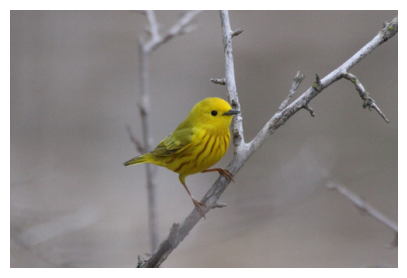

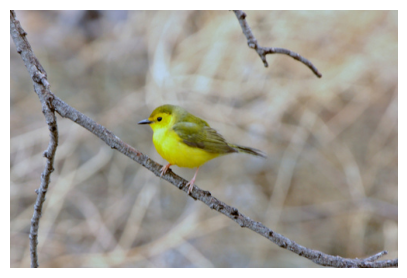

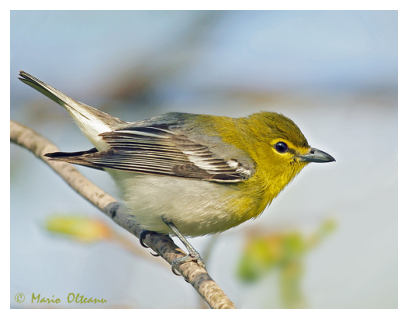

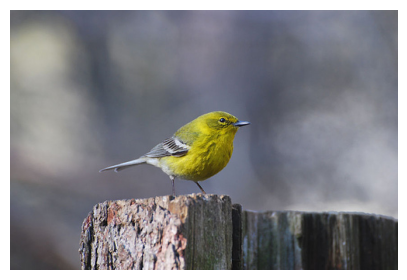

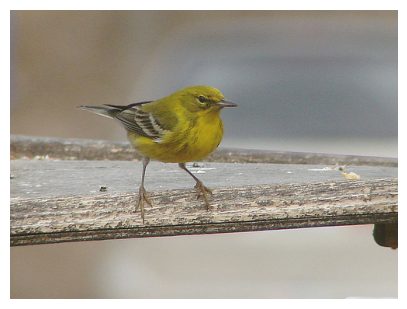

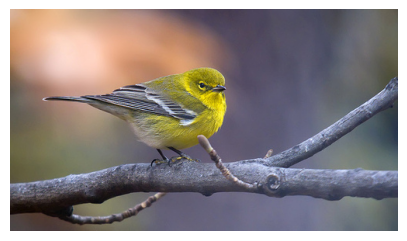

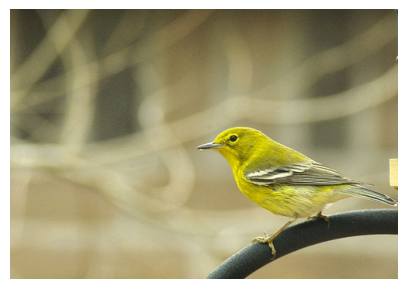

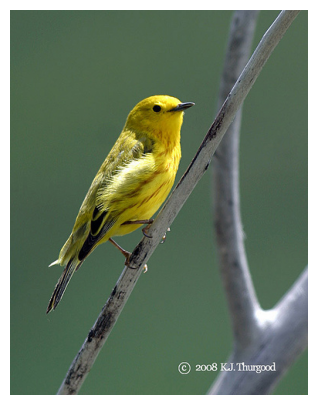

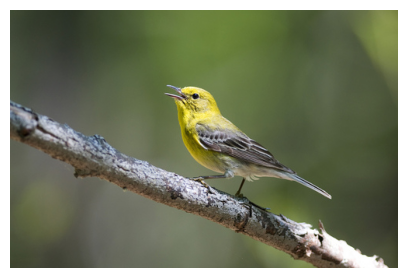

In [66]:
lon = len(resultadoFINAL)
for i in range(0,lon-1):
  img = PILImage.create(resultadoFINAL[i][0][1])
  print(resultadoFINAL[i][0][1])
  img.show()


Podemos observar en general que nuestro modelo ha confundido pájaros que realmente son BASTANTE parecidos, en color tamaño y forma.